In [1]:
"""
    # Example: Change duration
    This showcases the effect of sudden changes in effective spreading-rate (or R)
    that can cause a temporary decrease in daily new cases.
    Non-hierarchical model using jhu data (no regions).

    Runtime ~ 3 min
"""

import datetime
import copy
import sys

import pymc3 as pm
import numpy as np
import pandas as pd
import theano
import theano.tensor as tt
import theano.tensor.signal.conv as tt_conv
import matplotlib as mpl
import matplotlib.pyplot as plt

try:
    import covid19_inference as cov19
except ModuleNotFoundError:
    sys.path.append("../")
    sys.path.append("../../")
    sys.path.append("../../../")
    import covid19_inference as cov19

In [60]:
def RKI_R(infected_t, window=4, gd=4):
    """ Calculate R value as published by the RKI on 2020-05-15
    in 'Erkäuterung der Schätzung der zeitlich variierenden Reproduktionszahl R'

    infected: Timeseries or trace, in general: last index is considered to calculate R
    window: averaging window, average over 4 days is default
    """
    r = np.zeros(infected_t.shape)  # Empty array with the same shape as Timeseries

    if window == 1:
        r[..., gd:] = infected_t[..., gd:] / infected_t[..., :-gd]
    else:
        if window == 7:
            offset = 1
        elif window == 4:
            offset = 0

        for t in range(window + gd, infected_t.shape[-1] - offset):
            # NOTE: R7_Wert[t-1] <- sum(data$NeuErk[t-0:6]) / sum(data&NeuErk[t-4:10])
            # Indexing in R (the stat-language) is inclusive, in numpy exclusive: upper boundary in sum is increased by 1

            right_block = infected_t[..., t - window : t]
            left_block = infected_t[..., t - window - gd : t - gd]

            r[..., t - 1 - offset] = np.sum(right_block, axis=-1) / np.sum(
                left_block, axis=-1
            )

    # mask of R_values that were not calculated to match time-index of output to input
    return np.ma.masked_where((r == 0) | np.isinf(r) | np.isnan(r), r)


def create_our_SIR(model, trace, cps=1):
    new_cases_obs, time = cov19.plot._get_array_from_trace_via_date(
        model, trace, "new_symptomatic", start=model.data_begin
    )

    diff_data_sim = model.diff_data_sim  # this should to match the input model
    num_days_forecast = 1  # we do not need a forecast, only inference
    
    if cps == 1:
        change_points = [
            dict(
                pr_mean_date_transient=datetime.datetime(2020, 3, 23),
                pr_sigma_date_transient=3,
                pr_median_lambda=0.2,
                pr_sigma_lambda=1,
            )
        ]
    elif cps==3:
        change_points = [
            dict(
                pr_mean_date_transient=datetime.datetime(2020, 3, 9),
                pr_sigma_date_transient=3,
                pr_median_lambda=0.2,
                pr_sigma_lambda=0.5,
            ),
            dict(
                pr_mean_date_transient=datetime.datetime(2020, 3, 16),
                pr_sigma_date_transient=1,
                pr_median_lambda=0.1,
                pr_sigma_lambda=0.5,
            ),
            dict(
                pr_mean_date_transient=datetime.datetime(2020, 3, 23),
                pr_sigma_date_transient=1,
                pr_median_lambda=0.05,
                pr_sigma_lambda=0.5,
            )
        ]

    params_model = dict(
        new_cases_obs=np.median(new_cases_obs, axis=0),
        data_begin=model.data_begin,
        fcast_len=num_days_forecast,
        diff_data_sim=diff_data_sim,
        N_population=83e6,
    )

    pr_delay = 5

    with cov19.model.Cov19Model(**params_model) as this_model:
        # Create the an array of the time dependent infection rate lambda
        lambda_t_log = cov19.model.lambda_t_with_sigmoids(
            pr_median_lambda_0=0.4,
            pr_sigma_lambda_0=0.5,
            change_points_list=change_points,  # The change point priors we constructed earlier
            name_lambda_t="lambda_t",  # Name for the variable in the trace (see later)
        )
        # set prior distribution for the recovery rate
        mu = pm.Lognormal(name="mu", mu=np.log(1 / 8), sigma=0.2)
        # This builds a decorrelated prior for I_begin for faster inference.
        # It is not necessary to use it, one can simply remove it and use the default argument
        # for pr_I_begin in cov19.SIR

        # Use lambda_t_log and mu to run the SIR model
        new_cases = cov19.model.SIR(
            lambda_t_log=lambda_t_log,
            mu=mu,
            name_new_I_t="new_I_t",
            name_I_t="I_t",
            name_I_begin="I_begin",
        )

        # Delay the cases by a lognormal reporting delay
        new_cases = cov19.model.delay_cases(
            cases=new_cases,
            name_cases="delayed_cases",
            name_delay="delay",
            name_width="delay-width",
            pr_mean_of_median=pr_delay,
            pr_sigma_of_median=0.2,
            pr_median_of_width=0.3,
        )
        
        # Define the likelihood, uses the new_cases_obs set as model parameter
        cov19.model.student_t_likelihood(new_cases)
    return this_model


# helper to showcase the reporting delay via lognormal
def delay_lognormal(inp, median, sigma, amplitude=1.0, dist_len=40):
    """ Delays input inp by lognormal distirbution using convolution """
    dist_len = tt.cast(dist_len, "int64")
    beta = cov19.model._utility.tt_lognormal(
        tt.arange(dist_len * 2), tt.log(median), sigma
    )

    def conv1d(inp, filt, amplitude=1.0):
        """ wraps theano conv2d function for 1d arrays """
        amplitude = tt.cast(amplitude, "float64")
        amplitude = tt.clip(amplitude, 1e-12, 1e9)  # Limit to prevent NANs

        zero = tt.zeros_like(inp)
        a0rp = tt.concatenate((inp, zero,), 0) * amplitude

        a0rp3d = tt.alloc(0.0, 1, a0rp.shape[0], 1)
        a0rp = tt.set_subtensor(a0rp3d[0, :, 0], a0rp)
        filt3d = tt.alloc(0.0, 1, filt.shape[0], 1)
        filt = tt.set_subtensor(filt3d[0, :, 0], filt)
        return tt_conv.conv2d(a0rp, filt, None, None, border_mode="full").flatten()

    return conv1d(inp, beta, amplitude)[: inp.shape[0]]


def get_lambda_t_3cp_from_paper():
    # hard coded time series of the median lamda values we inferred
    # as in Fig 3 https://arxiv.org/abs/2004.01105
    y = np.array(
[2.3092174,  2.3092174,  2.3092174,  2.3092174,  2.3092174,  2.3092174,
 2.3092174,  2.3092174,  2.3092174,  2.3092174,  2.3092174 , 2.3092174,
 2.3092174,  2.3092174,  2.30886901, 2.30444046, 2.28558086, 2.22214028,
 2.06424004, 1.79814185, 1.42436909, 1.05682109, 0.89799516, 0.83343541,
 0.80789437, 0.79472849, 0.77099342, 0.70295616, 0.60137637, 0.50582961,
 0.44085193, 0.41479244, 0.4023683,  0.38046616, 0.33700696, 0.28827871,
 0.251765,   0.23365921, 0.22668192, 0.22452438, 0.224113  , 0.22400466,
 0.22400466, 0.22400466, 0.22400466, 0.22400466, 0.22400466, 0.22400466,
 0.22400466, 0.22400466, 0.22400466, 0.22400466, 0.22400466, 0.22400466,
 0.22400466, 0.22400466, 0.22400466, 0.22400466, 0.22400466, 0.22400466,
 0.22400466, 0.22400466, 0.22400466, 0.22400466, 0.22400466, 0.22400466,
 0.22400466, 0.22400466, 0.22400466, 0.22400466, 0.22400466, 0.22400466,
 0.22400466, 0.22400466, 0.22400466, 0.22400466, 0.22400466, 0.22400466,
 0.22400466, 0.22400466, 0.22400466, 0.22400466, 0.22400466, 0.22400466,]
    )

    x = pd.date_range(start="2020-2-15", periods=len(y)).date
    
    return y, x


# we want to create multiple models with the different change points
def create_fixed_model(params_model, cp_center, cp_duration, lambda_new):
    with cov19.model.Cov19Model(**params_model) as this_model:

        # usually, make lambda a pymc3 random variable.
        # In this toymodel, we set to a fixed value
        # lambda_old = pm.Lognormal("lambda", mu=0.39, sigma=0.5)
        lambda_old = tt.constant(lambda_fixed)
        pm.Deterministic("lambda", lambda_old)

        # convert date-arguments to (integer) days
        cp_center = (cp_center - this_model.sim_begin).days

        # create a simple time series with the change-point as a smooth step:
        # linear interpolation between 0 and 1
        time_array = np.arange(this_model.sim_len)
        step_t = tt.clip((time_array - cp_center + cp_duration / 2) / cp_duration, 0, 1)

        # create the time series of lambda (on log scale)
        lambda_t = step_t * (lambda_new - lambda_old) + lambda_old
        pm.Deterministic("lambda_t", lambda_t)

        # based on the timeseries of the rates, get new cases (infected) via SIR
        # needs lambda_t on log scale
        new_I_t, new_E_t, I_t, S_t = cov19.model.SEIR(
            lambda_t_log=tt.log(lambda_t),
            mu=mu_fixed,
            # new exposed per day: infected but not infectious yet
            name_new_E_t="new_E_t",
            # new infectious per day
            name_new_I_t="new_I_t",
            # incubation period, lognormal distributed, duration in the E pool
            pr_mean_median_incubation=4,
            name_median_incubation="median_incubation",
            # fix I_begin, new_E_begin and incubation time instead of inferring them
            # with pymc3
            pr_I_begin=tt.constant(100, dtype="float64"),
            # dirty workaround, we need shape 11 for the convolution running in SEIR
            pr_new_E_begin=tt.ones(11, dtype="float64") * 50,
            # another dirty workaround so we keep one free variable but it is alwys the same effectively
            pr_sigma_median_incubation=0.1,
            return_all=True,
        )
        pm.Deterministic("mu", tt.constant(mu_fixed))

        # SIR our paper
        # delay: S->Reported
        #   * fixed timeshift with lognormal prior
        #   * in ensemble average: lognomal delay
        #   * different from lognormal convolution
        #   * hence, different dynamics

        # SIR now:
        #   * lognorm conv. with (log?)normal prior (kernel) of median
        #   * hence, the delay influences the dynamic within each trace / sample

        # 3 delays: (all pools new per day)
        # Infected -> Infectious        | E->I  | pr_median ~ 4 (in paper 5)
        # Infectious -> Sympotmatic     |       | Rki Refdatum ~ 1 day, not in the code
        # Symptomatic -> Reported       |       | Rki Meldedatum

        # RKI:
        #    Infected -> Infectious  | E         | "Serial interval" 4 days
        #    Infected -> Sympotmatic | E +delay  | "Incubation period" 4-6 days

        # Plots
        # Infected          | E
        # Symptomatic       | E + .. delay ..           | ~ 4-6 day | check cori et al 2013, machtes rki
        # Reported          | I + ^^ large ^^ delay
        #   -> Tests are performed without symptoms, and can be positive when in I pool

        # incubation period
        new_symptomatic = delay_lognormal(inp=new_E_t, median=5, sigma=0.3, dist_len=30)
        pm.Deterministic("new_symptomatic", new_symptomatic)

        # the other stuff
        new_reported = delay_lognormal(inp=new_I_t, median=7, sigma=0.3, dist_len=30)
        pm.Deterministic("new_reported", new_reported)

        # here, we do not need to optimize the parameters and can skip the likelihood
        # cov19.model.student_t_likelihood(cases=new_cases)

    return this_model


def create_3cp_model(params_model):
    with cov19.model.Cov19Model(**params_model) as this_model:

        lambda_t, t = get_lambda_t_3cp_from_paper()
        # get the right time-range
        start = np.where(t == this_model.sim_begin.date())[0][0]
        lambda_t = tt.constant(lambda_t[start:])
        pm.Deterministic("lambda_t", lambda_t)

        # based on the timeseries of the rates, get new cases (infected) via SIR
        # needs lambda_t on log scale
        new_I_t, new_E_t, I_t, S_t = cov19.model.SEIR(
            lambda_t_log=tt.log(lambda_t),
            mu=mu_fixed,
            # new exposed per day: infected but not infectious yet
            name_new_E_t="new_E_t",
            # new infectious per day
            name_new_I_t="new_I_t",
            # incubation period, lognormal distributed, duration in the E pool
            pr_mean_median_incubation=4,
            name_median_incubation="median_incubation",
            # fix I_begin, new_E_begin and incubation time instead of inferring them
            # with pymc3
            pr_I_begin=tt.constant(100, dtype="float64"),
            # dirty workaround, we need shape 11 for the convolution running in SEIR
            pr_new_E_begin=tt.ones(11, dtype="float64") * 50,
            # another dirty workaround so we keep one free variable but it is alwys the same effectively
            pr_sigma_median_incubation=0.1,
            return_all=True,
        )
        pm.Deterministic("mu", tt.constant(mu_fixed))

        # SIR our paper
        # delay: S->Reported
        #   * fixed timeshift with lognormal prior
        #   * in ensemble average: lognomal delay
        #   * different from lognormal convolution
        #   * hence, different dynamics

        # SIR now:
        #   * lognorm conv. with (log?)normal prior (kernel) of median
        #   * hence, the delay influences the dynamic within each trace / sample

        # 3 delays: (all pools new per day)
        # Infected -> Infectious        | E->I  | pr_median ~ 4 (in paper 5)
        # Infectious -> Sympotmatic     |       | Rki Refdatum ~ 1 day, not in the code
        # Symptomatic -> Reported       |       | Rki Meldedatum

        # RKI:
        #    Infected -> Infectious  | E         | "Serial interval" 4 days
        #    Infected -> Sympotmatic | E +delay  | "Incubation period" 4-6 days

        # Plots
        # Infected          | E
        # Symptomatic       | E + .. delay ..           | ~ 4-6 day | check cori et al 2013, machtes rki
        # Reported          | I + ^^ large ^^ delay
        #   -> Tests are performed without symptoms, and can be positive when in I pool

        # incubation period
        new_symptomatic = delay_lognormal(inp=new_E_t, median=5, sigma=0.3, dist_len=30)
        pm.Deterministic("new_symptomatic", new_symptomatic)

        # the other stuff
        new_reported = delay_lognormal(inp=new_I_t, median=7, sigma=0.3, dist_len=30)
        pm.Deterministic("new_reported", new_reported)
    return this_model


def plot_distributions(model, trace):
    fig, axes = plt.subplots(6, 3, figsize=(6, 6.4))

    for i, key in enumerate(
        # left column
        ["weekend_factor", "mu", "lambda_0", "lambda_1", "lambda_2", "lambda_3"]
    ):
        try:
            cov19.plot._distribution(model, trace, key, ax=axes[i, 0])
        except:
            print(f"{key} not in vars")

    for i, key in enumerate(
        # mid column
        [
            "offset_modulation",
            "sigma_obs",
            "I_begin",
            "transient_day_1",
            "transient_day_2",
            "transient_day_3",
        ]
    ):
        try:
            cov19.plot._distribution(model, trace, key, ax=axes[i, 1])
        except:
            print(f"{key} not in vars")

    for i, key in enumerate(
        # right column
        ["delay", "transient_len_1", "transient_len_2", "transient_len_3",]
    ):
        try:
            cov19.plot._distribution(model, trace, key, ax=axes[i + 2, 2])
        except:
            print(f"{key} not in vars")

    fig.tight_layout()
    return fig, axes

In [ ]:
# ------------------------------------------------------------------------------ #
# Start here
# ------------------------------------------------------------------------------ #
cov19.log.loglevel = "DEBUG"

# limit the data range to exponential growth
bd = datetime.datetime(2020, 3, 2)
ed = datetime.datetime(2020, 3, 15)

# download data
# the toy model could do without data but the toolbox assumes some realworld data.
jhu = cov19.data_retrieval.JHU(auto_download=True)
cum_cases = jhu.get_total(country="Germany", data_begin=bd, data_end=ed)
new_cases = jhu.get_new(country="Germany", data_begin=bd, data_end=ed)

# set model parameters
params_model = dict(
    new_cases_obs=new_cases,
    data_begin=bd,
    fcast_len=45,
    diff_data_sim=16,
    N_population=83e6,
)

# hard coded recovery rate and initial spreading rate, R ~ 3
mu_fixed = 1/3
lambda_fixed = 1.3

"""
Create dummy data with fixed parameters and
run it to obtain a dataset which we later use as new cases obs.
"""
mod = dict()
mod["a"] = create_fixed_model(
    params_model,
    cp_center=datetime.datetime(2020, 3, 23),
    cp_duration=0.1,
    lambda_new=0.4,
)
mod["b"] = create_fixed_model(
    params_model,
    cp_center=datetime.datetime(2020, 3, 23),
    cp_duration=4,
    lambda_new=0.4,
)
mod["c"] = create_fixed_model(
    params_model,
    cp_center=datetime.datetime(2020, 3, 23),
    cp_duration=8,
    lambda_new=0.4,
)
mod["d"] = create_3cp_model(params_model)

tr = dict()
tr["a"] = pm.sample(model=mod["a"])
tr["b"] = pm.sample(model=mod["b"])
tr["c"] = pm.sample(model=mod["c"])
tr["d"] = pm.sample(model=mod["d"])

"""
Use our dummy data to run a new model
"""
sir_mod = dict()
sir_mod["a"] = create_our_SIR(mod["a"], tr["a"])
sir_mod["b"] = create_our_SIR(mod["b"], tr["b"])
sir_mod["c"] = create_our_SIR(mod["c"], tr["c"])
sir_mod["d"] = create_our_SIR(mod["d"], tr["d"], cps=3)

sir_tr = dict()
sir_tr["a"] = pm.sample(model=sir_mod["a"], tune=500, draws=500, init="advi+adapt_diag")
sir_tr["b"] = pm.sample(model=sir_mod["b"], tune=500, draws=500, init="advi+adapt_diag")
sir_tr["c"] = pm.sample(model=sir_mod["c"], tune=500, draws=500, init="advi+adapt_diag")
sir_tr["d"] = pm.sample(model=sir_mod["d"], tune=500, draws=500, init="advi+adapt_diag")



INFO     [covid19_inference.data_retrieval._JHU] Successfully loaded data from local
INFO     [covid19_inference.model.compartmental_models] SEIR
INFO     [covid19_inference.model.compartmental_models] SEIR
INFO     [covid19_inference.model.compartmental_models] SEIR
INFO     [covid19_inference.model.compartmental_models] SEIR
Auto-assigning NUTS sampler...
INFO     [pymc3] Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
INFO     [pymc3] Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
INFO     [pymc3] Multiprocess sampling (4 chains in 4 jobs)
NUTS: [median_incubation]
INFO     [pymc3] NUTS: [median_incubation]
Sampling 4 chains, 0 divergences: 100%|██████████| 4000/4000 [00:03<00:00, 1092.50draws/s]
The acceptance probability does not match the target. It is 0.8917590601459506, but should be close to 0.8. Try to increase the number of tuning steps.
WARNING  [pymc3] The acceptance probability does not match the target.

/scratch.local/jdehning/anaconda3/lib/python3.7/site-packages/numpy/core/fromnumeric.py:746: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedArray.
  a.partition(kth, axis=axis, kind=kind, order=order)
/scratch.local/jdehning/anaconda3/lib/python3.7/site-packages/numpy/core/fromnumeric.py:746: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedArray.
  a.partition(kth, axis=axis, kind=kind, order=order)
/scratch.local/jdehning/anaconda3/lib/python3.7/site-packages/numpy/core/fromnumeric.py:746: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedArray.
  a.partition(kth, axis=axis, kind=kind, order=order)
/scratch.local/jdehning/anaconda3/lib/python3.7/site-packages/numpy/core/fromnumeric.py:746: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedArray.
  a.partition(kth, axis=axis, kind=kind, order=order)
/scratch.local/jdehning/anaconda3/lib/python3.7/site-packages/numpy/core/fromnumeric.py:746: UserWarning

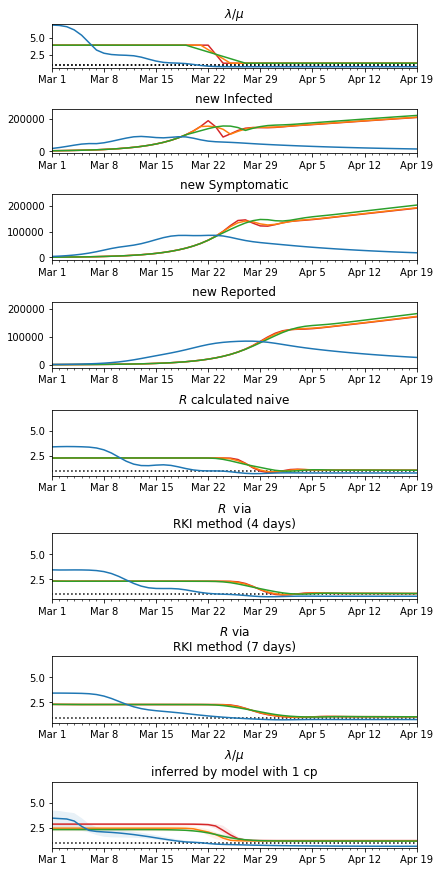

In [62]:
"""
    ## Plotting
"""
cov19.plot.set_rcparams(cov19.plot.get_rcparams_default())
cov19.plot.rcParams.draw_ci_50 = False
cov19.plot.rcParams.draw_ci_75 = False
cov19.plot.rcParams.draw_ci_95 = False

fig, axes = plt.subplots(
    8,
    1,
    figsize=(6, 12),
    gridspec_kw={"height_ratios": [2, 2, 3, 3, 3, 3, 3, 3]},
    constrained_layout=True,
)

for key, clr in zip(
    ["a", "b", "c", "d"], ["tab:red", "tab:orange", "tab:green", "tab:blue"]
):
    trace = tr[key]
    model = mod[key]

    mu = trace["mu"][:, None]
    lambda_t, x = cov19.plot._get_array_from_trace_via_date(model, trace, "lambda_t")

    # R
    ax = axes[0]
    y = lambda_t[:, :] / mu
    cov19.plot._timeseries(x=x, y=y, ax=ax, what="model", color=clr)
    ax.set_title(r"$\lambda / \mu$")
    ax.set_ylim(0.0, 3.3)
    if key == "a":
        # only annotate once
        ax.hlines(1, x[0], x[-1], linestyles=":")

    # New infected, not infectious
    ax = axes[1]
    y, x = cov19.plot._get_array_from_trace_via_date(model, trace, "new_E_t")
    cov19.plot._timeseries(x=x, y=y, ax=ax, what="model", color=clr)
    ax.set_title("new Infected")

    # New symptomatic
    ax = axes[2]
    y, x = cov19.plot._get_array_from_trace_via_date(model, trace, "new_symptomatic")
    cov19.plot._timeseries(x=x, y=y, ax=ax, what="model", color=clr)
    ax.set_title("new Symptomatic")

    # New reported
    ax = axes[3]
    y, x = cov19.plot._get_array_from_trace_via_date(model, trace, "new_reported")
    cov19.plot._timeseries(x=x, y=y, ax=ax, what="model", color=clr)
    ax.set_title("new Reported")

    # ------------------------------------------------------------------------------ #
    # Comparisson for different calculation of R
    # ------------------------------------------------------------------------------ #

    # generation duration
    gd = 4

    # R inferred naive: R_t = Sy_t / Sy_t-gd, gd=4 generation time
    ax = axes[4]
    y, x = cov19.plot._get_array_from_trace_via_date(model, trace, "new_symptomatic")
    # R naive as in-degree
    # y = [y[:,i+gd]/y[:,i] for i in range(model.sim_len-gd)]
    # cov19.plot._timeseries(x=x[:-4], y=np.transpose(np.array(y)), ax=ax, what="model", color=clr)
    # R naive as out-degree
    y = [y[:, i] / y[:, i - gd] for i in range(gd, model.sim_len)]
    cov19.plot._timeseries(
        x=x[gd:], y=np.transpose(np.array(y)), ax=ax, what="model", color=clr
    )
    ax.set_title(r"$R$ calculated naive")

    # R rki avg 4: on Symptomatics
    ax = axes[5]
    y, x = cov19.plot._get_array_from_trace_via_date(model, trace, "new_symptomatic")
    cov19.plot._timeseries(
        x=x, y=RKI_R(y, window=4, gd=gd), ax=ax, what="model", color=clr
    )
    ax.set_title(r"$R$  via" + "\n" + "RKI method (4 days)")

    # R rki avg 7: on Symptomatics
    ax = axes[6]
    y, x = cov19.plot._get_array_from_trace_via_date(model, trace, "new_symptomatic")
    cov19.plot._timeseries(
        x=x, y=RKI_R(y, window=7, gd=gd), ax=ax, what="model", color=clr
    )
    ax.set_title(r"$R$ via" + "\n" + "RKI method (7 days)")

    # R inferred with our model (1cp)
    trace = sir_tr[key]
    model = sir_mod[key]
    mu = trace["mu"]
    ax = axes[7]
    lambda_t, x = cov19.plot._get_array_from_trace_via_date(model, trace, "lambda_t")
    y = lambda_t[:, :] / trace["mu"][:, None]
    cov19.plot._timeseries(x=x, y=y, ax=ax, what="model", color=clr, draw_ci_75=True)
    ax.set_title(r"$\lambda / \mu$" + "\n" + "inferred by model with 1 cp")

    # "if what we inferred (3CP!) was correct, what would the R inferred via RKi etc. look like?!"
    #   * plug in the estimates we inferred in the paper as (fixed) values for the SEIR generation

    """
    * R not 3 but ~ 2
        * not due to smaller slope (symptomatic vs infected)
            - using infected gives same R_0 values
        * smaller R maybe due to convolution
    * other generation duration
    * posteriors of our model

    """

for idx, ax in enumerate(axes):
    ax.set_xlim(datetime.datetime(2020, 3, 1), datetime.datetime(2020, 4, 19))
    if idx >= 4 or idx==0:
        ax.set_ylim(0.5, 7.1)
        ax.hlines(1, x[0], x[-1], linestyles=":")

plt.savefig("comparisson_different_R.png")
# Finally plot distributions for the model

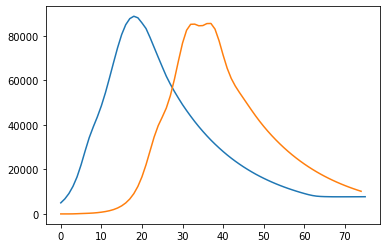

In [63]:
y, x = cov19.plot._get_array_from_trace_via_date(mod['d'], tr['d'], "new_symptomatic")
plt.plot(np.median(sir_tr["d"].delayed_cases, axis=0))
plt.plot(np.median(y, axis=0))